In [1]:
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
)
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 2",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
]

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [2]:
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
100%|████████████████████████████████████████| 300/300 [00:12<00:00, 23.66it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
experiments, outcomes = results

C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


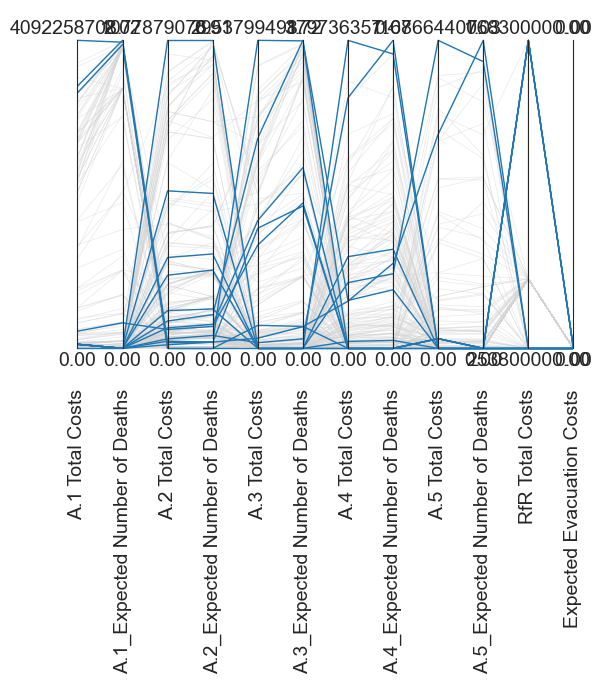

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)
#axes.invert_axis('max_P')

fig = plt.gcf()

plt.show()

In [5]:
print(all_data.idxmax())
print(all_data.idxmin())

A.1 Total Costs                  165
A.1_Expected Number of Deaths    135
A.2 Total Costs                   17
A.2_Expected Number of Deaths     17
A.3 Total Costs                   65
A.3_Expected Number of Deaths     95
A.4 Total Costs                   94
A.4_Expected Number of Deaths     57
A.5 Total Costs                   70
A.5_Expected Number of Deaths     73
RfR Total Costs                  100
Expected Evacuation Costs          0
dtype: int64
A.1 Total Costs                  108
A.1_Expected Number of Deaths      0
A.2 Total Costs                  101
A.2_Expected Number of Deaths    101
A.3 Total Costs                    2
A.3_Expected Number of Deaths      2
A.4 Total Costs                    0
A.4_Expected Number of Deaths      0
A.5 Total Costs                    0
A.5_Expected Number of Deaths      0
RfR Total Costs                    0
Expected Evacuation Costs          0
dtype: int64


In [6]:
# also all we need are the uncertainty columns
selected = experiments.loc[[184,124], ['A.1_pfail', 'A.1_Bmax', 'A.1_Brate', 'A.2_pfail', 'A.2_Bmax', 'A.2_Brate','A.3_pfail', 'A.3_Bmax', 'A.3_Brate','A.4_pfail', 'A.4_Bmax', 'A.4_Brate','A.5_pfail', 'A.5_Bmax', 'A.5_Brate', 'discount rate 0','discount rate 1','discount rate 2','A.0_ID flood wave shape']]
selected

,A.1_pfail,A.1_Bmax,A.1_Brate,A.2_pfail,A.2_Bmax,A.2_Brate,A.3_pfail,A.3_Bmax,A.3_Brate,A.4_pfail,A.4_Bmax,A.4_Brate,A.5_pfail,A.5_Bmax,A.5_Brate,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape
184,0.461691,68.317495,10.0,0.628742,44.486784,1.5,0.181570,90.811488,1.0,0.665243,348.217472,1.0,0.660093,181.268819,10.0,2.5,4.5,1.5,57
124,0.291338,120.703790,10.0,0.152278,144.234075,10.0,0.209038,254.626933,1.5,0.119085,78.006495,10.0,0.251955,35.301592,1.0,1.5,1.5,4.5,15


In [7]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [8]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.em_framework import optimization

def transform_variables_fixed(problem, variables):
    converted_vars = []
    for type, var in zip(problem.types, variables):
        if isinstance(var, (list, tuple)):
            var = type.decode(var)
            try:
                var = var[0]
            except TypeError:
                pass
        converted_vars.append(var)
    return converted_vars
from ema_workbench.em_framework import optimization
from ema_workbench.util.ema_exceptions import EMAError
from platypus import Solution

def rebuild_platypus_population_fixed(archive, problem):
    solutions = []

    for _, row in archive.iterrows():
        try:
            decision_variables = [row[attr] for attr in problem.parameter_names]
        except KeyError:
            missing_parameters = [attr for attr in problem.parameter_names if attr not in row]
            raise EMAError(f"Parameter names {missing_parameters} not found in archive")

        try:
            objectives = [row[attr] for attr in problem.outcome_names]
        except KeyError:
            missing_outcomes = [attr for attr in problem.outcome_names if attr not in row]
            raise EMAError(f"Outcome names {missing_outcomes} not found in archive")

        solution = Solution(problem)

        # ✅ the clean, warning-free way:
        solution.variables[:] = decision_variables
        solution.objectives[:] = objectives

        solutions.append(solution)

    return solutions

# Monkeypatch the function
optimization.rebuild_platypus_population = rebuild_platypus_population_fixed
optimization.transform_variables = transform_variables_fixed
def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []
    problem = to_problem(model, searchover="levers")

    with MultiprocessingEvaluator(model) as evaluator:
        for i in range(5):
            convergence_metrics = [
                ArchiveLogger(
                    "./archives",
                    [l.name for l in model.levers],
                    [o.name for o in model.outcomes],
                    base_filename=f"assignment_final_{scenario.name}_seed_{i}.tar.gz",
                ),
                EpsilonProgress(),
            ]

            result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                         convergence=convergence_metrics,
                                         epsilons=epsilons,
                                         reference=scenario)

            results.append(result)
            convergences.append(convergence)
    
    # merge the results using a non-dominated sort  
    reference_set = epsilon_nondominated(results, epsilons, problem)
    
    return reference_set, convergences


results = []
for scenario in scenarios:
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    # note that 100000 nfe is again rather low to ensure proper convergence
    results.append(optimize(scenario, 1e2, dike_model, epsilons))

[MainProcess/INFO] pool started with 16 workers
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 21.93it/s]
[MainProcess/INFO] optimization completed, found 73 solutions
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.11it/s]
[MainProcess/INFO] optimization completed, found 76 solutions
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.02it/s]
[MainProcess/INFO] optimization completed, found 66 solutions
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.24it/s]
[MainProcess/INFO] optimization completed, found 59 solutions
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.37it/s]
[MainProcess/INFO] optimization completed, found 62 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 16 workers
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.21it/s]
[MainProcess/INFO] optimization completed, found 73 solutions
100%|███████████

In [9]:
from platypus import Hypervolume
from ema_workbench.em_framework.optimization import rebuild_platypus_population


def calculate_convergence_metrics(problem, archives_file):
    #hv = Hypervolume(minimum=[0, 0, 0, 0], maximum=[12, 3, 1, 1])
    hv = Hypervolume(
    minimum=[0] * problem.nobjs,
    maximum=[2000] * problem.nobjs)
    archives = ArchiveLogger.load_archives(archives_file)
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(hypervolume=hv.calculate(population), nfe=nfe))
        
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)    
    return metrics


problem = to_problem(dike_model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenarios):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/assignment_final_{scenario.name}_seed_{seed}.tar.gz"
        metrics = calculate_convergence_metrics(problem, archive_file)
        metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress   
        
        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

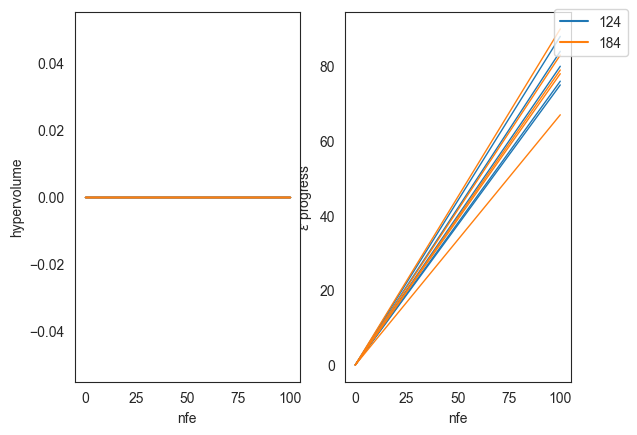

In [10]:
import matplotlib as mpl
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(ncols=2)

colors = sns.color_palette()

legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    # we use this for a custom legend
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax1.plot(score.nfe, score.hypervolume, c=color, lw=1)
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)


ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

# create our custom legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()

In [11]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [12]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(2, policies=policies)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 2 scenarios * 433 policies * 1 model(s) = 866 experiments
100%|████████████████████████████████████████| 866/866 [00:33<00:00, 25.73it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
experiments, outcomes = reeevaluation_results

# setup a dataframe for the outcomes
# we add scenario and policy as additional columns
# we need scenario because regret is calculated on a scenario by scenario basis
# we add policy because we need to get the maximum regret for each policy.
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    best = x.min(numeric_only=True)
    regret = x.loc[:, best.index] - best
    regret['policy'] = x.policy
    return regret


# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

C:\Users\tangu\AppData\Local\Temp\ipykernel_21712\3746536876.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tangu\AppData\Local\Temp\ipykernel_21712\3746536876.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tangu\AppData\Local\Temp\ipykernel_21712\3746536876.py:22: FutureWarning: The default of observed=False is deprecated and

C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


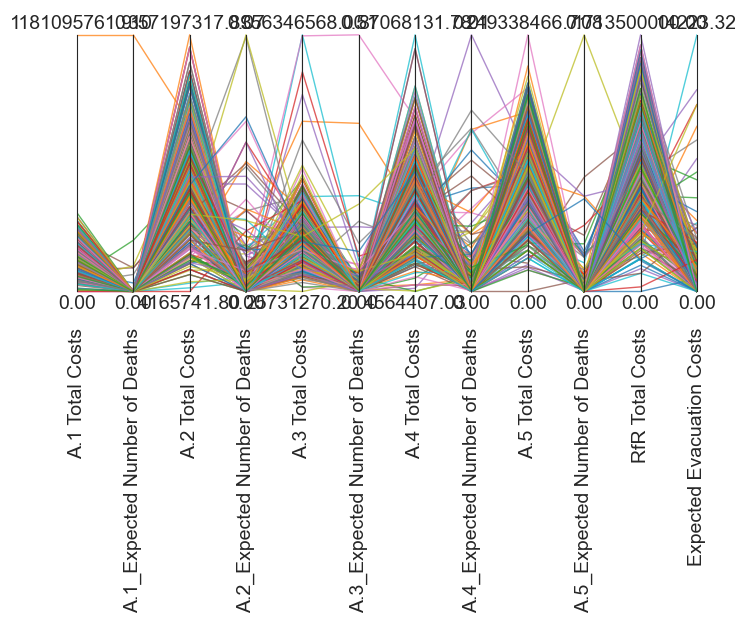

In [14]:
limits = parcoords.get_limits(max_regret)
paraxes = parcoords.ParallelAxes(max_regret)
paraxes.plot(max_regret, lw=1, alpha=0.75)

# let's resize the figure a bit
fig = plt.gcf()
fig.set_size_inches(8, 4)

plt.show()